# Proprocess

### Imports

In [65]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from pathlib import Path
from skimage.feature import hog
from sklearn.metrics.pairwise import cosine_similarity
from ultralytics import YOLO
from IPython.display import Image, display
%matplotlib inline
import random
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import roc_curve, auc



## Pre-processing

### Merged bbox and annotations

In [54]:
bbox = pd.read_csv("content/bbox.csv")
annotations = pd.read_csv("content/annotations.csv")

bbox["image_name_clean"] = bbox["image_name"].str.lower().str.strip()
annotations["path_clean"] = annotations["path"].str.lower().str.strip()

merged = pd.merge(bbox, annotations, left_on="image_name_clean", right_on="path_clean", how="inner")

print("merged: ", len(merged))

merged.head()

merged:  160


,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height,image_name_clean,identity,path,orientation,date,path_clean
0,head,1214,888,645,561,leftIMG_0328.jpeg,5472,3648,leftimg_0328.jpeg,SE010,leftIMG_0328.jpeg,left,24_06_2021,leftimg_0328.jpeg
1,head,1511,966,1110,736,leftIMG_0344.jpg,5472,3648,leftimg_0344.jpg,G16-03,leftIMG_0344.jpg,left,14_06_2019,leftimg_0344.jpg
2,head,847,2974,846,855,leftIMG_0597.jpg,3648,5472,leftimg_0597.jpg,G16-03,leftIMG_0597.jpg,left,21_06_2018,leftimg_0597.jpg
3,head,1692,850,1110,1026,leftIMG_0715.jpg,5472,3648,leftimg_0715.jpg,G18-04,leftIMG_0715.jpg,left,15_06_2019,leftimg_0715.jpg
4,head,1569,785,723,523,leftIMG_0751.jpeg,5472,3648,leftimg_0751.jpeg,t573,leftIMG_0751.jpeg,left,25_06_2021,leftimg_0751.jpeg


### Cropped turtle head

In [55]:
output_dir = "dataset_turtle_cropped"
os.makedirs(output_dir, exist_ok=True)

for _, row in merged.iterrows():
    img_path = os.path.join("content/images", row["image_name"])
    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    x, y, w, h = map(int, [row["bbox_x"], row["bbox_y"], row["bbox_width"], row["bbox_height"]])
    crop = img[y:y+h, x:x+w]

    id_folder = os.path.join(output_dir, row["identity"])
    os.makedirs(id_folder, exist_ok=True)

    save_path = os.path.join(id_folder, row["image_name"])
    cv2.imwrite(save_path, crop)

print(f"Cropped turtle heads saved to: {output_dir}")

Cropped turtle heads saved to: dataset_turtle_cropped


### dataset_turtle_preprocessed
- grayscale
- Noise reduction (Gaussian blur)
- Histogram equalization
- Resize to standard size

In [56]:
cropped_dir = "dataset_turtle_cropped"
preprocessed_dir = "dataset_turtle_preprocessed"
os.makedirs(preprocessed_dir, exist_ok=True)

standard_size = (224, 224)

for identity_folder in os.listdir(cropped_dir):
    cropped_identity_path = os.path.join(cropped_dir, identity_folder)
    if not os.path.isdir(cropped_identity_path):
        continue

    preprocessed_identity_path = os.path.join(preprocessed_dir, identity_folder)
    os.makedirs(preprocessed_identity_path, exist_ok=True)

    for img_name in os.listdir(cropped_identity_path):
        img_path = os.path.join(cropped_identity_path, img_name)
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        denoised = cv2.GaussianBlur(gray, (5, 5), 0)
        equalized = cv2.equalizeHist(denoised)
        resized = cv2.resize(equalized, standard_size)

        save_path = os.path.join(preprocessed_identity_path, img_name)
        cv2.imwrite(save_path, resized)

print(f"Preprocessing complete. Saved to: {preprocessed_dir}")

Preprocessing complete. Saved to: dataset_turtle_preprocessed


# Data Augmentation

> Add blockquote



### dataset_turtle_preprocessed_Augmentation
อันนี้เพิ่ม
- Augmentation เข้าไป (ทำ 3 ครั้งต่อ 1 ภาพ)

In [57]:
preprocessed_dir = "dataset_turtle_preprocessed"
output_dir = "dataset_turtle_preprocessed_Augmentation"
os.makedirs(output_dir, exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5)
])

STANDARD_SIZE = (224, 224)

for identity_folder in os.listdir(preprocessed_dir):
    identity_path = os.path.join(preprocessed_dir, identity_folder)
    if not os.path.isdir(identity_path):
        continue

    output_identity_path = os.path.join(output_dir, identity_folder)
    os.makedirs(output_identity_path, exist_ok=True)

    for img_name in os.listdir(identity_path):
        img_path = os.path.join(identity_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img = cv2.GaussianBlur(img, (5,5), 0)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        img = cv2.resize(img, STANDARD_SIZE)

        # save original
        save_path = os.path.join(output_identity_path, img_name)
        cv2.imwrite(save_path, img)

        # 3 augmentations
        for i in range(3):
            augmented = transform(image=img)
            aug_img = augmented['image']
            aug_name = img_name.replace(".", f"_aug{i}.")
            cv2.imwrite(os.path.join(output_identity_path, aug_name), aug_img)

print(f"Data augmentation complete. Saved to: {output_dir}")

/home/philiphousden/miniconda3/envs/tf/lib/python3.9/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Data augmentation complete. Saved to: dataset_turtle_preprocessed_Augmentation


### Rotation (Registration)

In [58]:
input_dir = "dataset_turtle_preprocessed_Augmentation"
output_dir = "dataset_turtle_registered"
os.makedirs(output_dir, exist_ok=True)

for identity_folder in os.listdir(input_dir):
    identity_path = os.path.join(input_dir, identity_folder)
    if not os.path.isdir(identity_path):
        continue

    output_identity_path = os.path.join(output_dir, identity_folder)
    os.makedirs(output_identity_path, exist_ok=True)

    for img_name in os.listdir(identity_path):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(identity_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
        c = max(contours, key=cv2.contourArea)

        if len(c) >= 5:
            ellipse = cv2.fitEllipse(c)
            angle = ellipse[2]
        else:
            M = cv2.moments(c)
            if M["mu20"] != 0:
                angle = 0.5 * np.arctan2(2 * M["mu11"], (M["mu20"] - M["mu02"])) * 180 / np.pi
            else:
                angle = 0

        (h, w) = img.shape[:2]
        center = (w // 2, h // 2)
        rot_matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)
        rotated = cv2.warpAffine(img, rot_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

        save_path = os.path.join(output_identity_path, img_name)
        cv2.imwrite(save_path, rotated)

print(f"Registration complete. Saved to: {output_dir}")

Registration complete. Saved to: dataset_turtle_registered


### Segmenation 

New https://pypi.org/project/ultralytics/8.3.223 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.203 🚀 Python-3.9.21 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=No

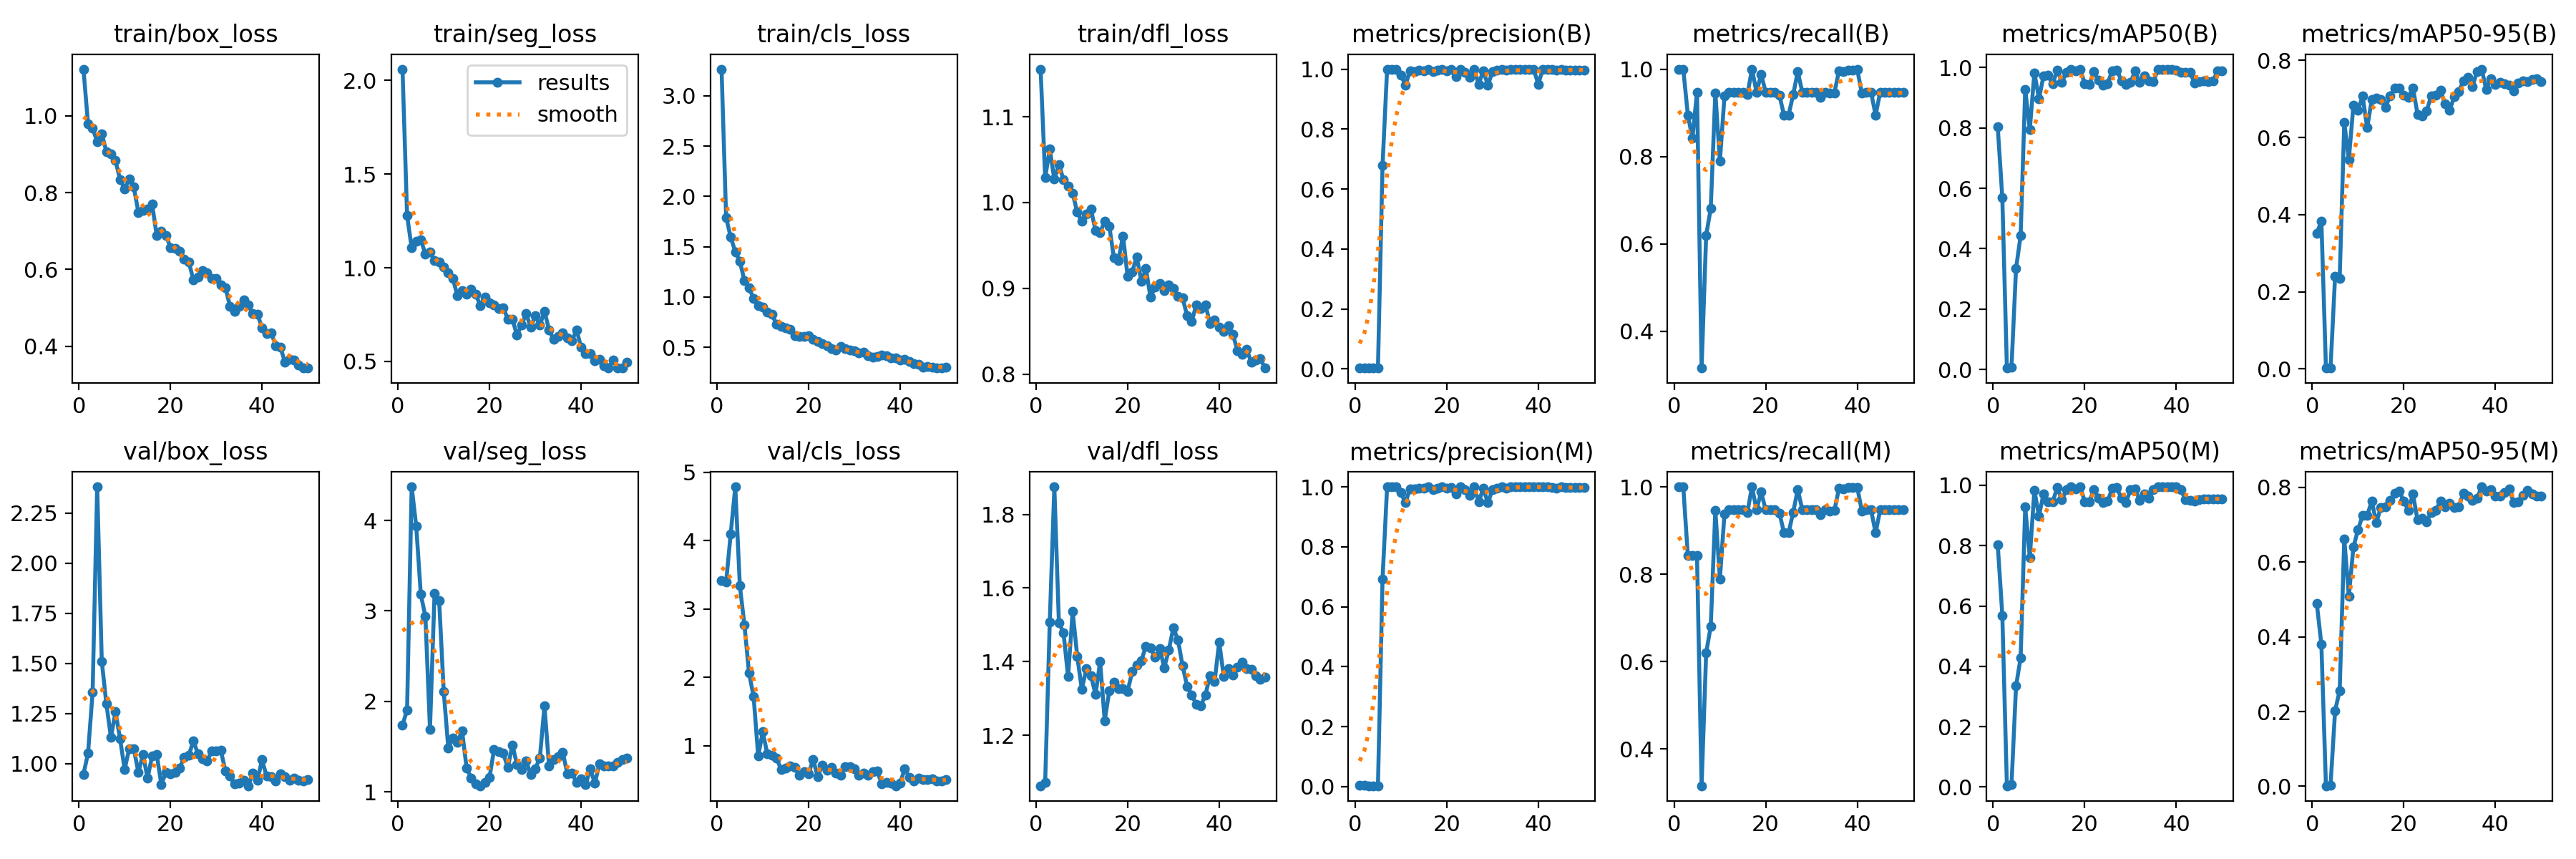

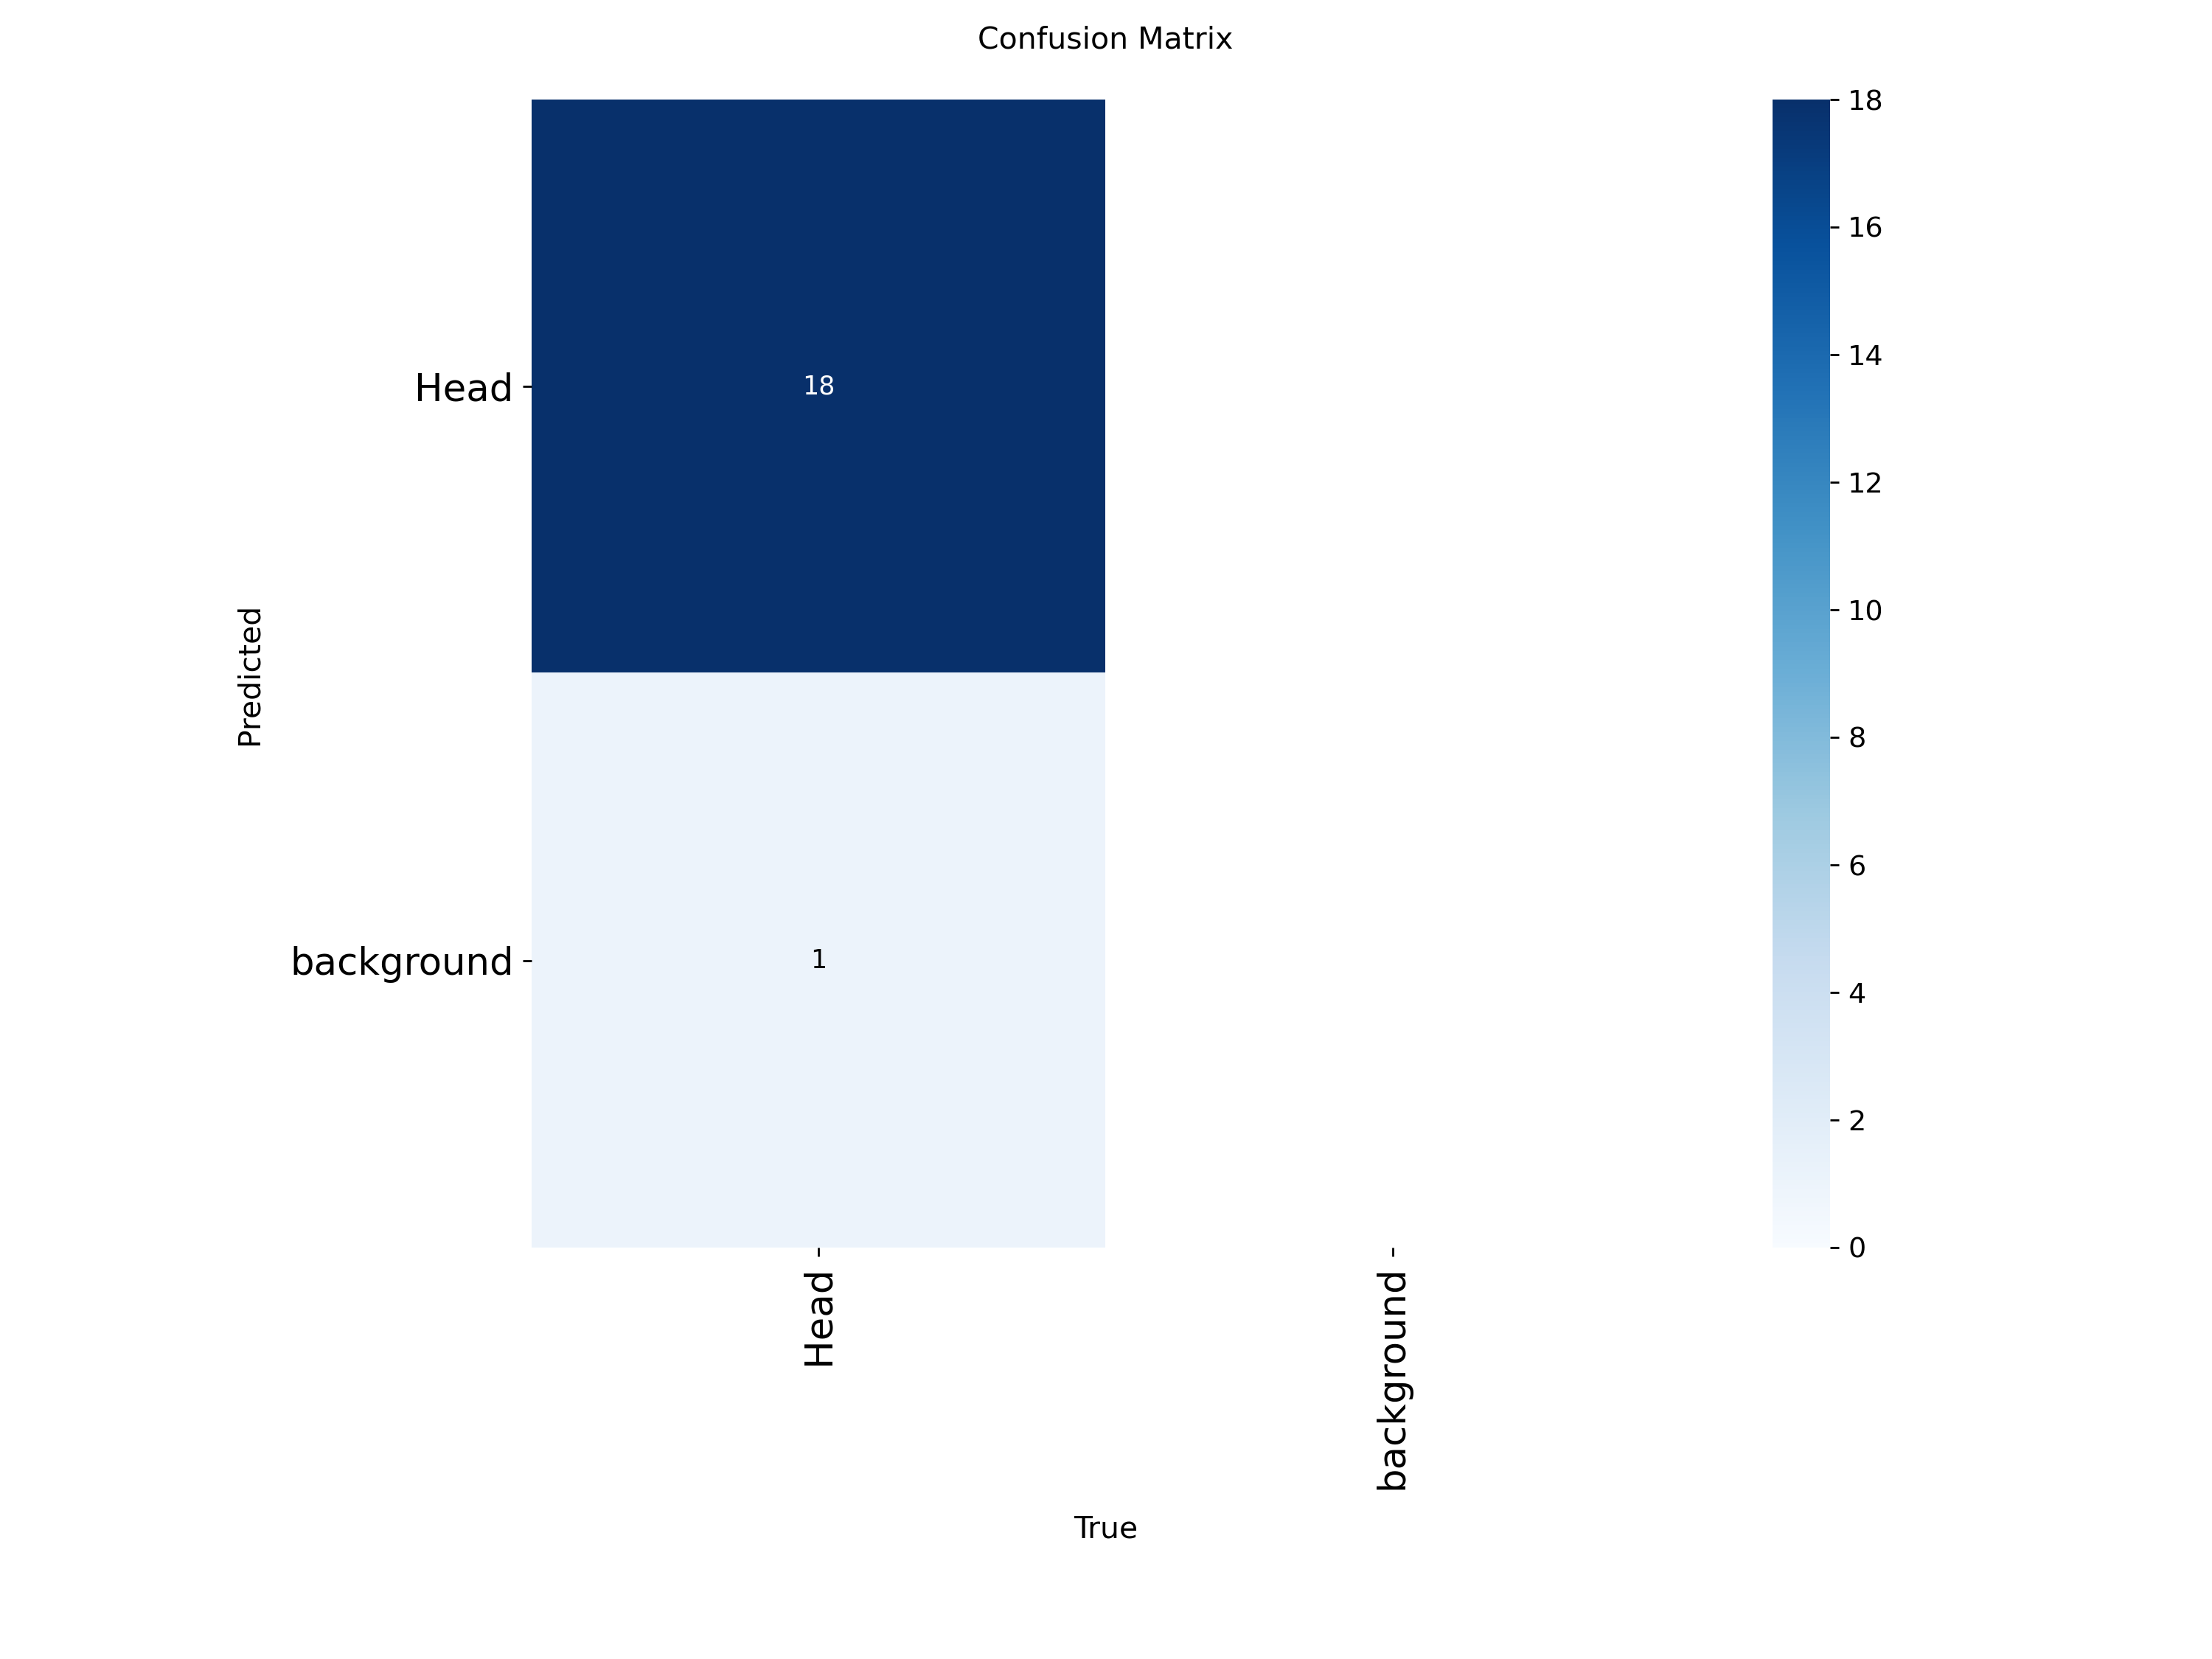

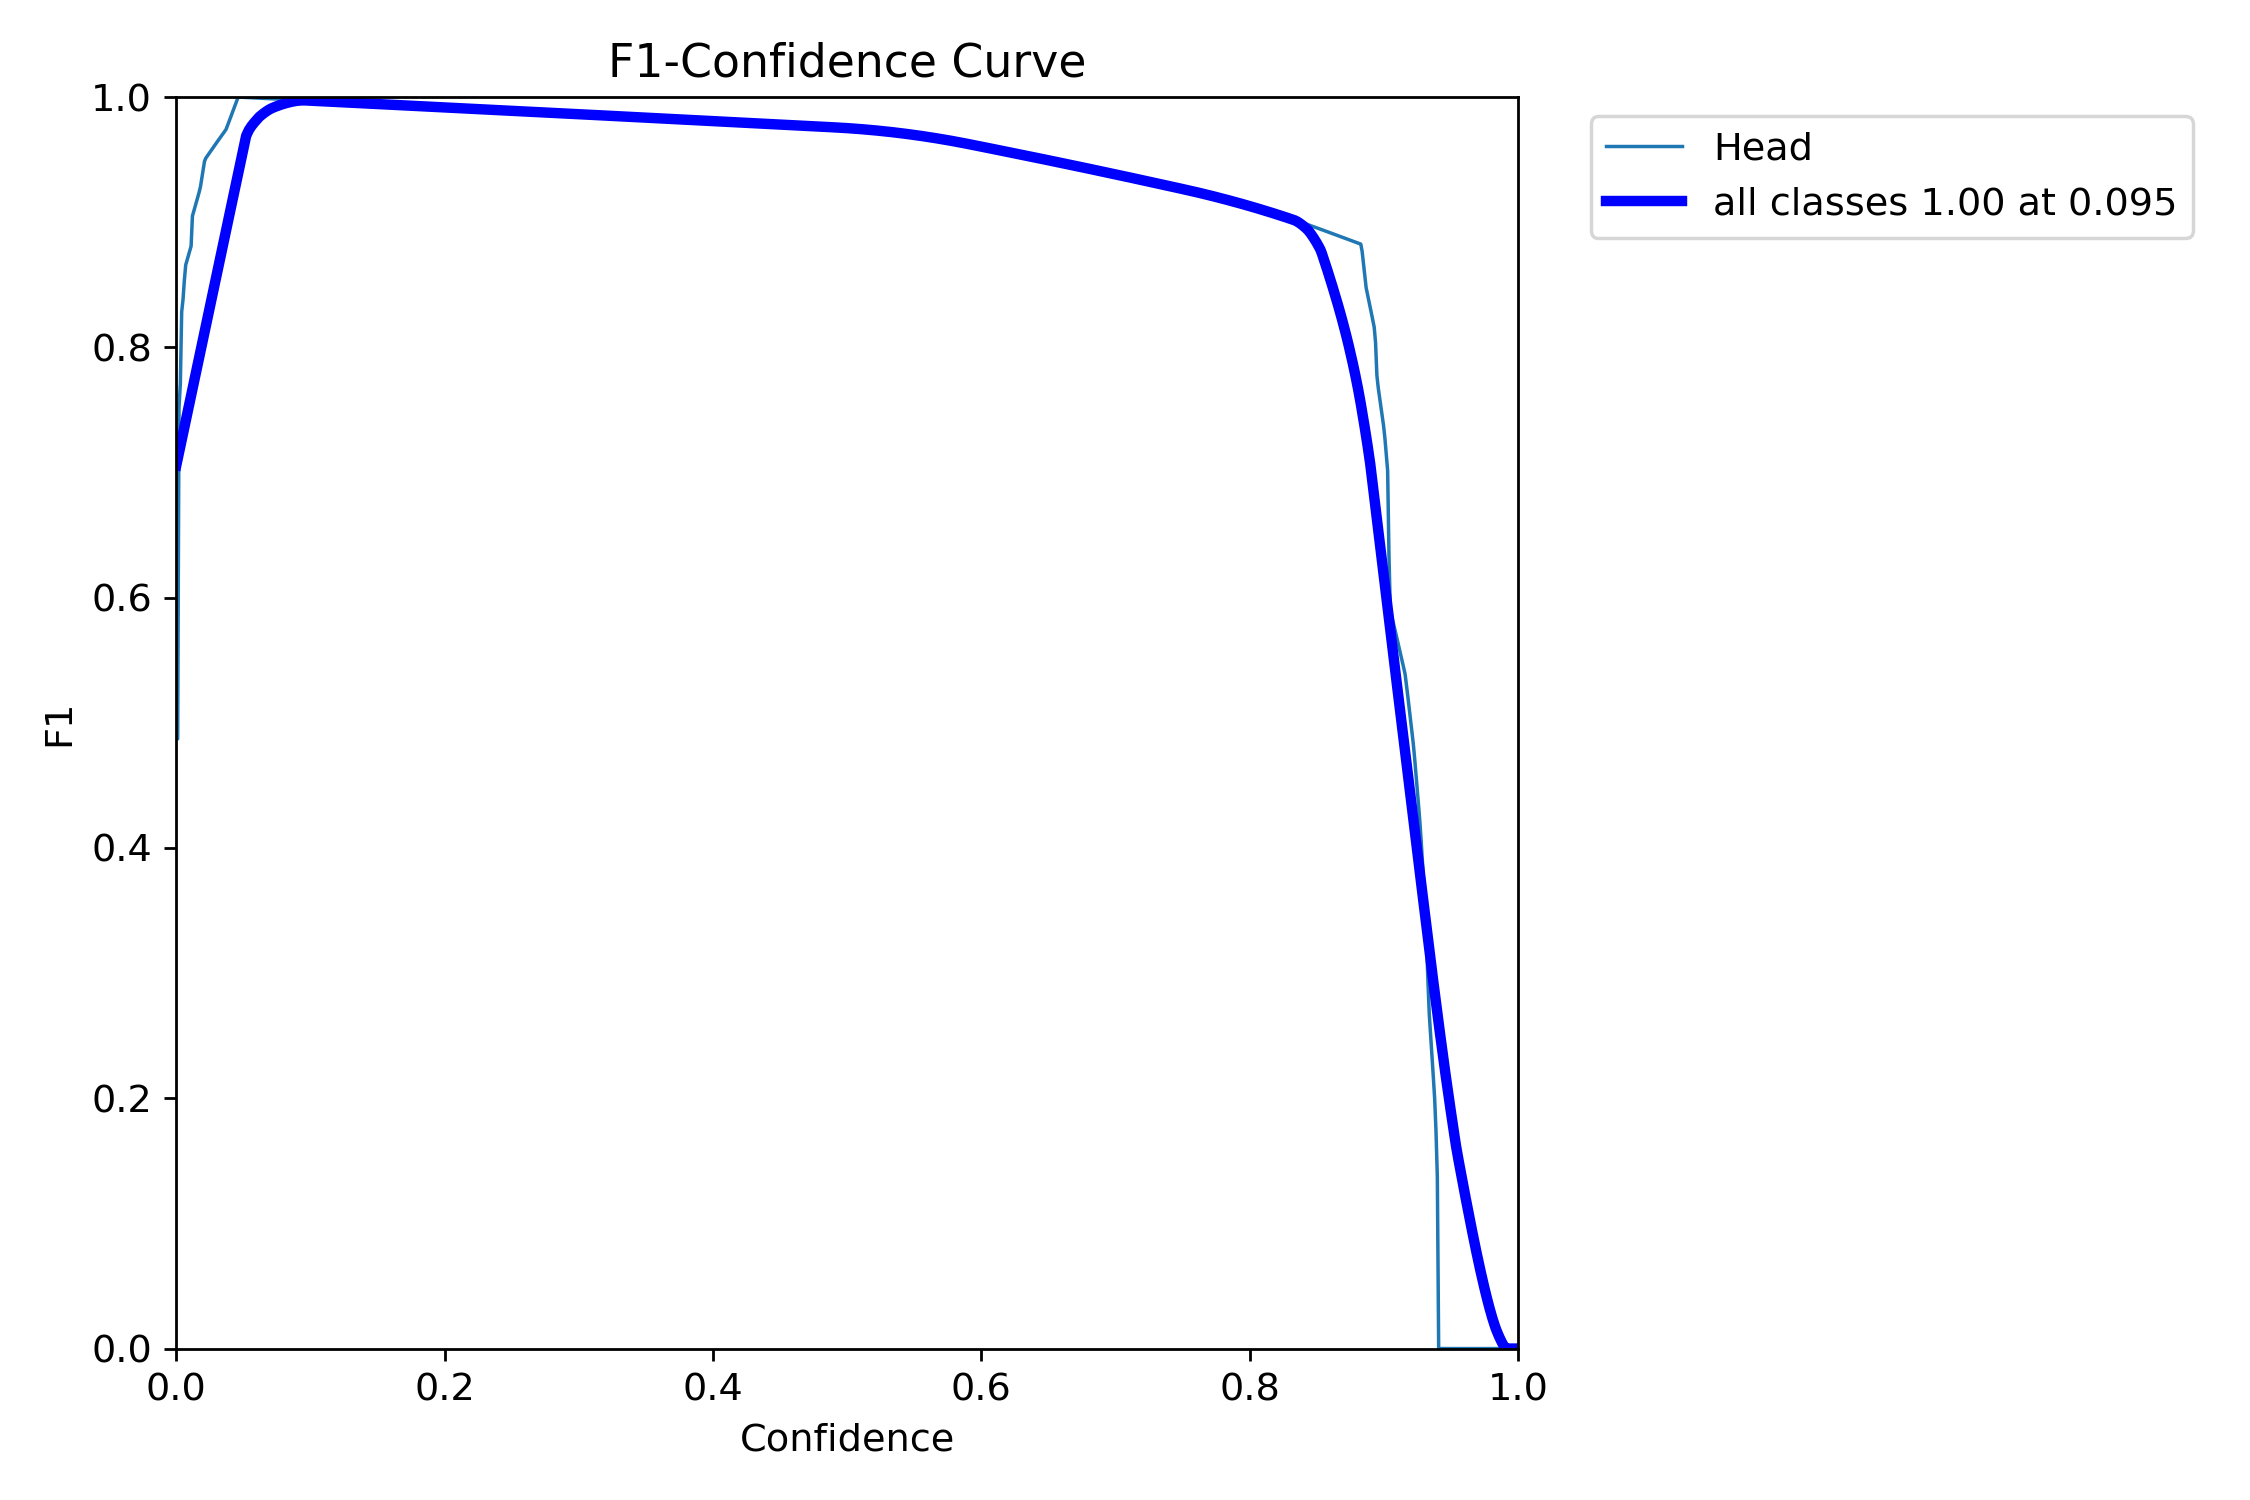

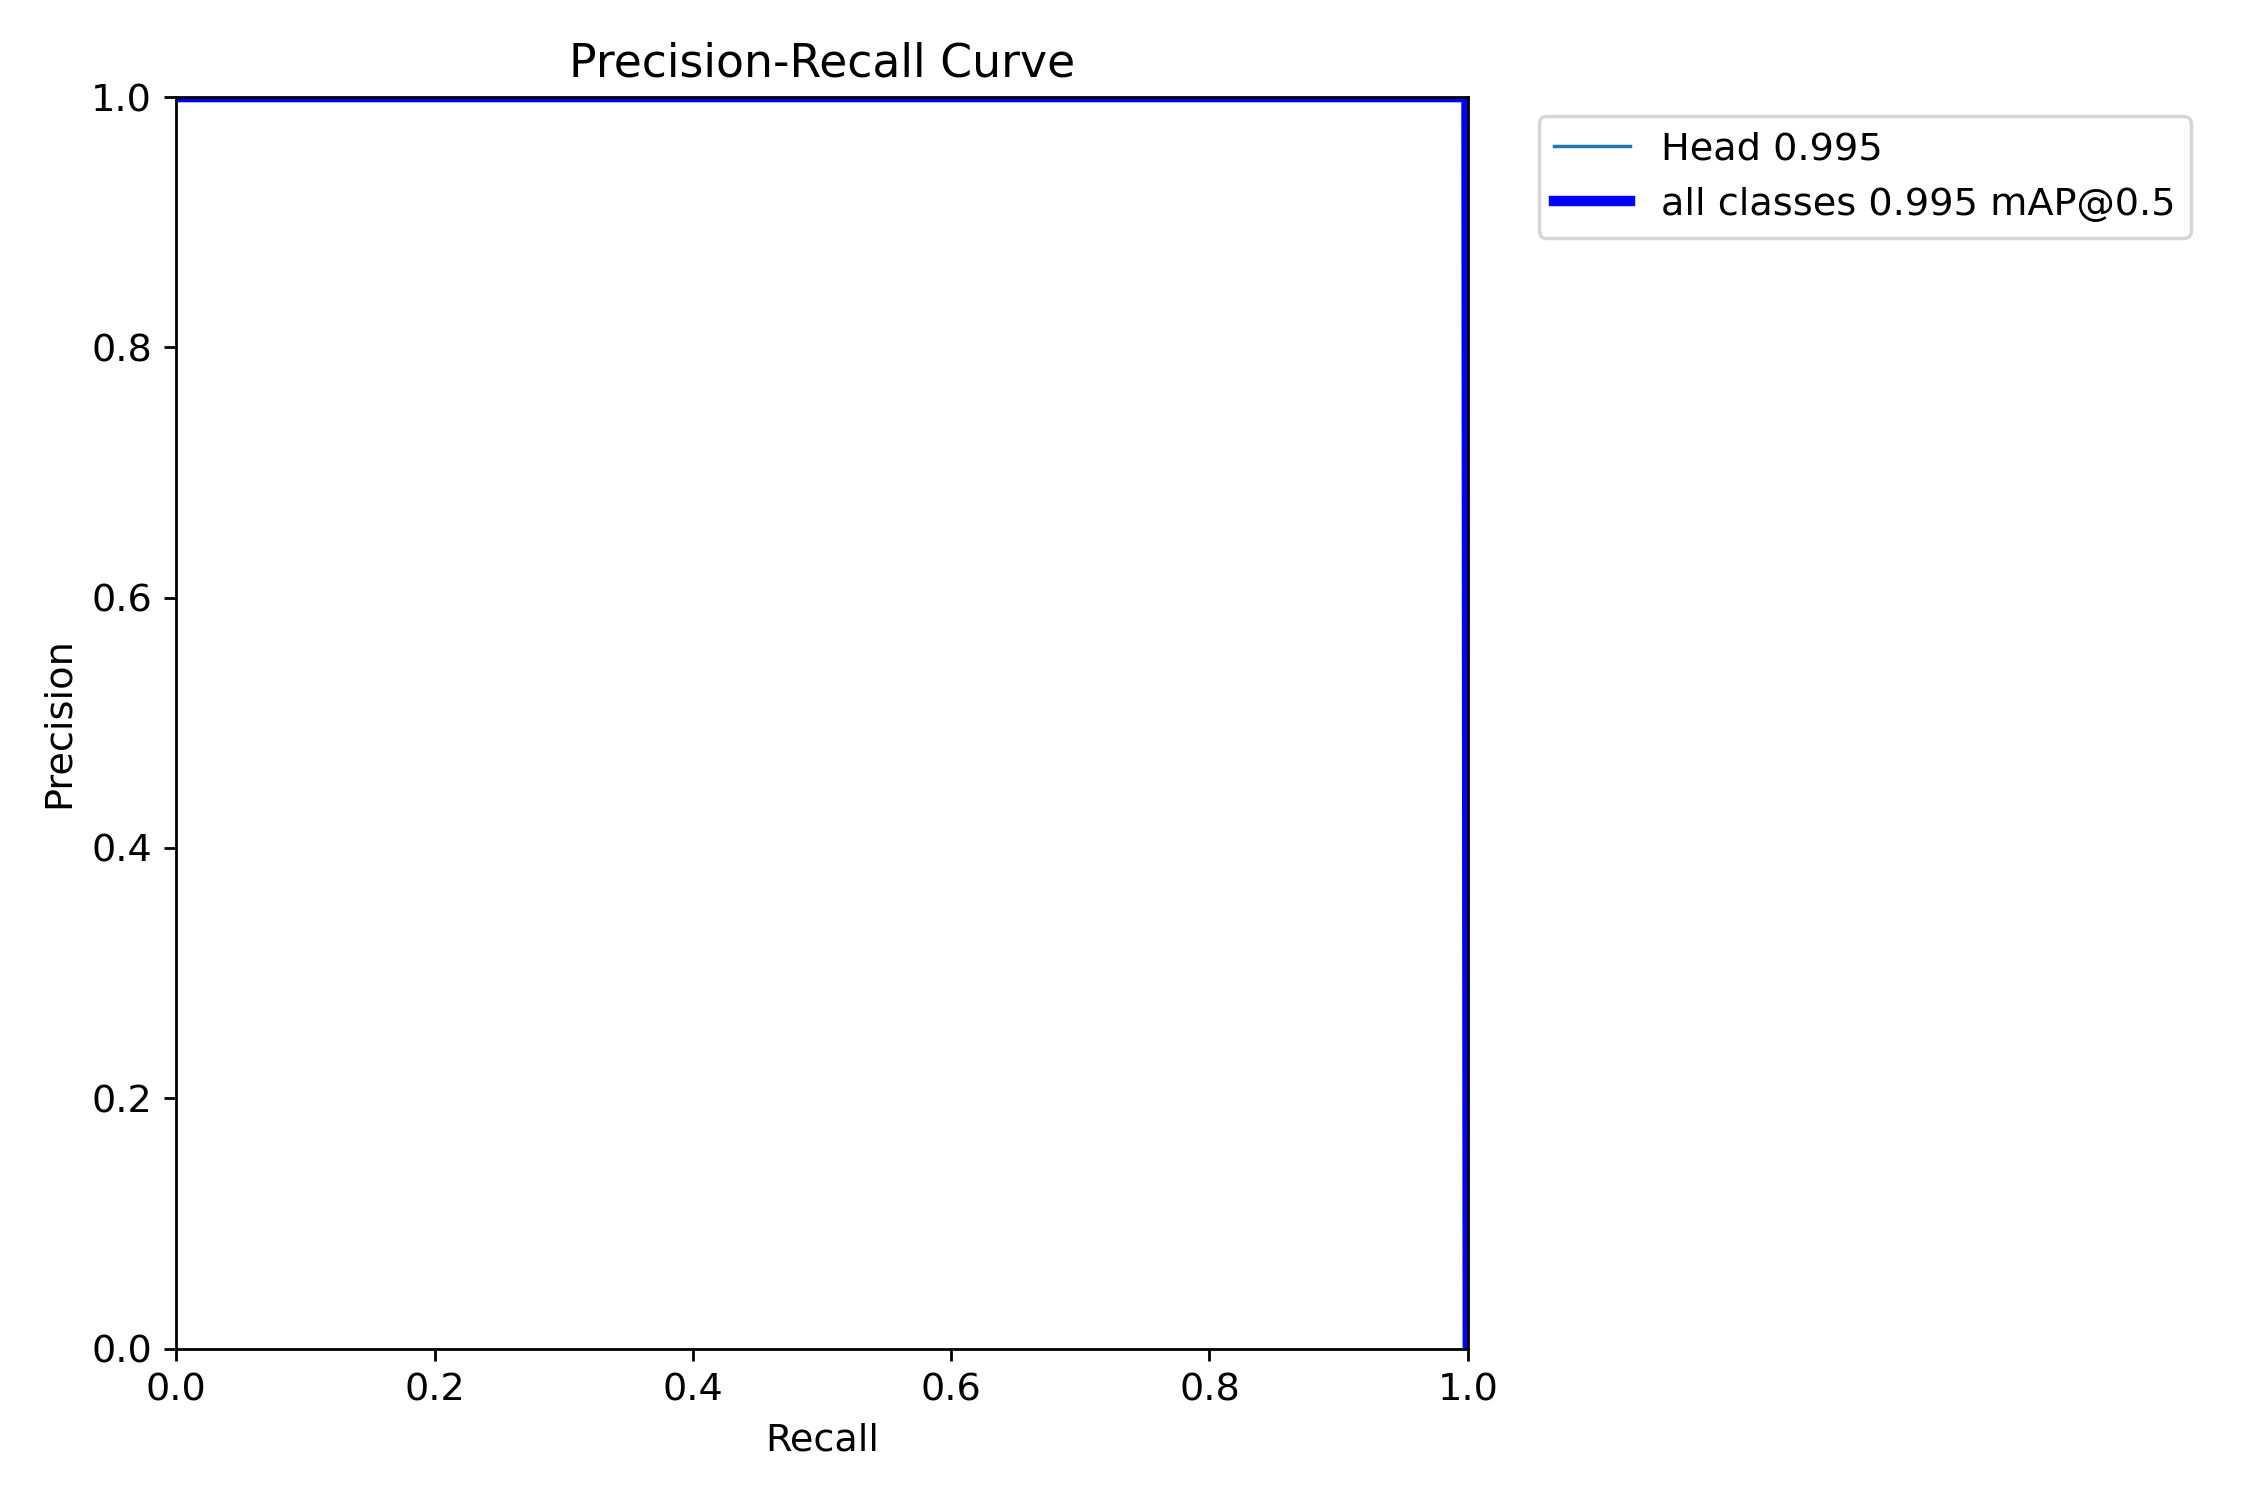

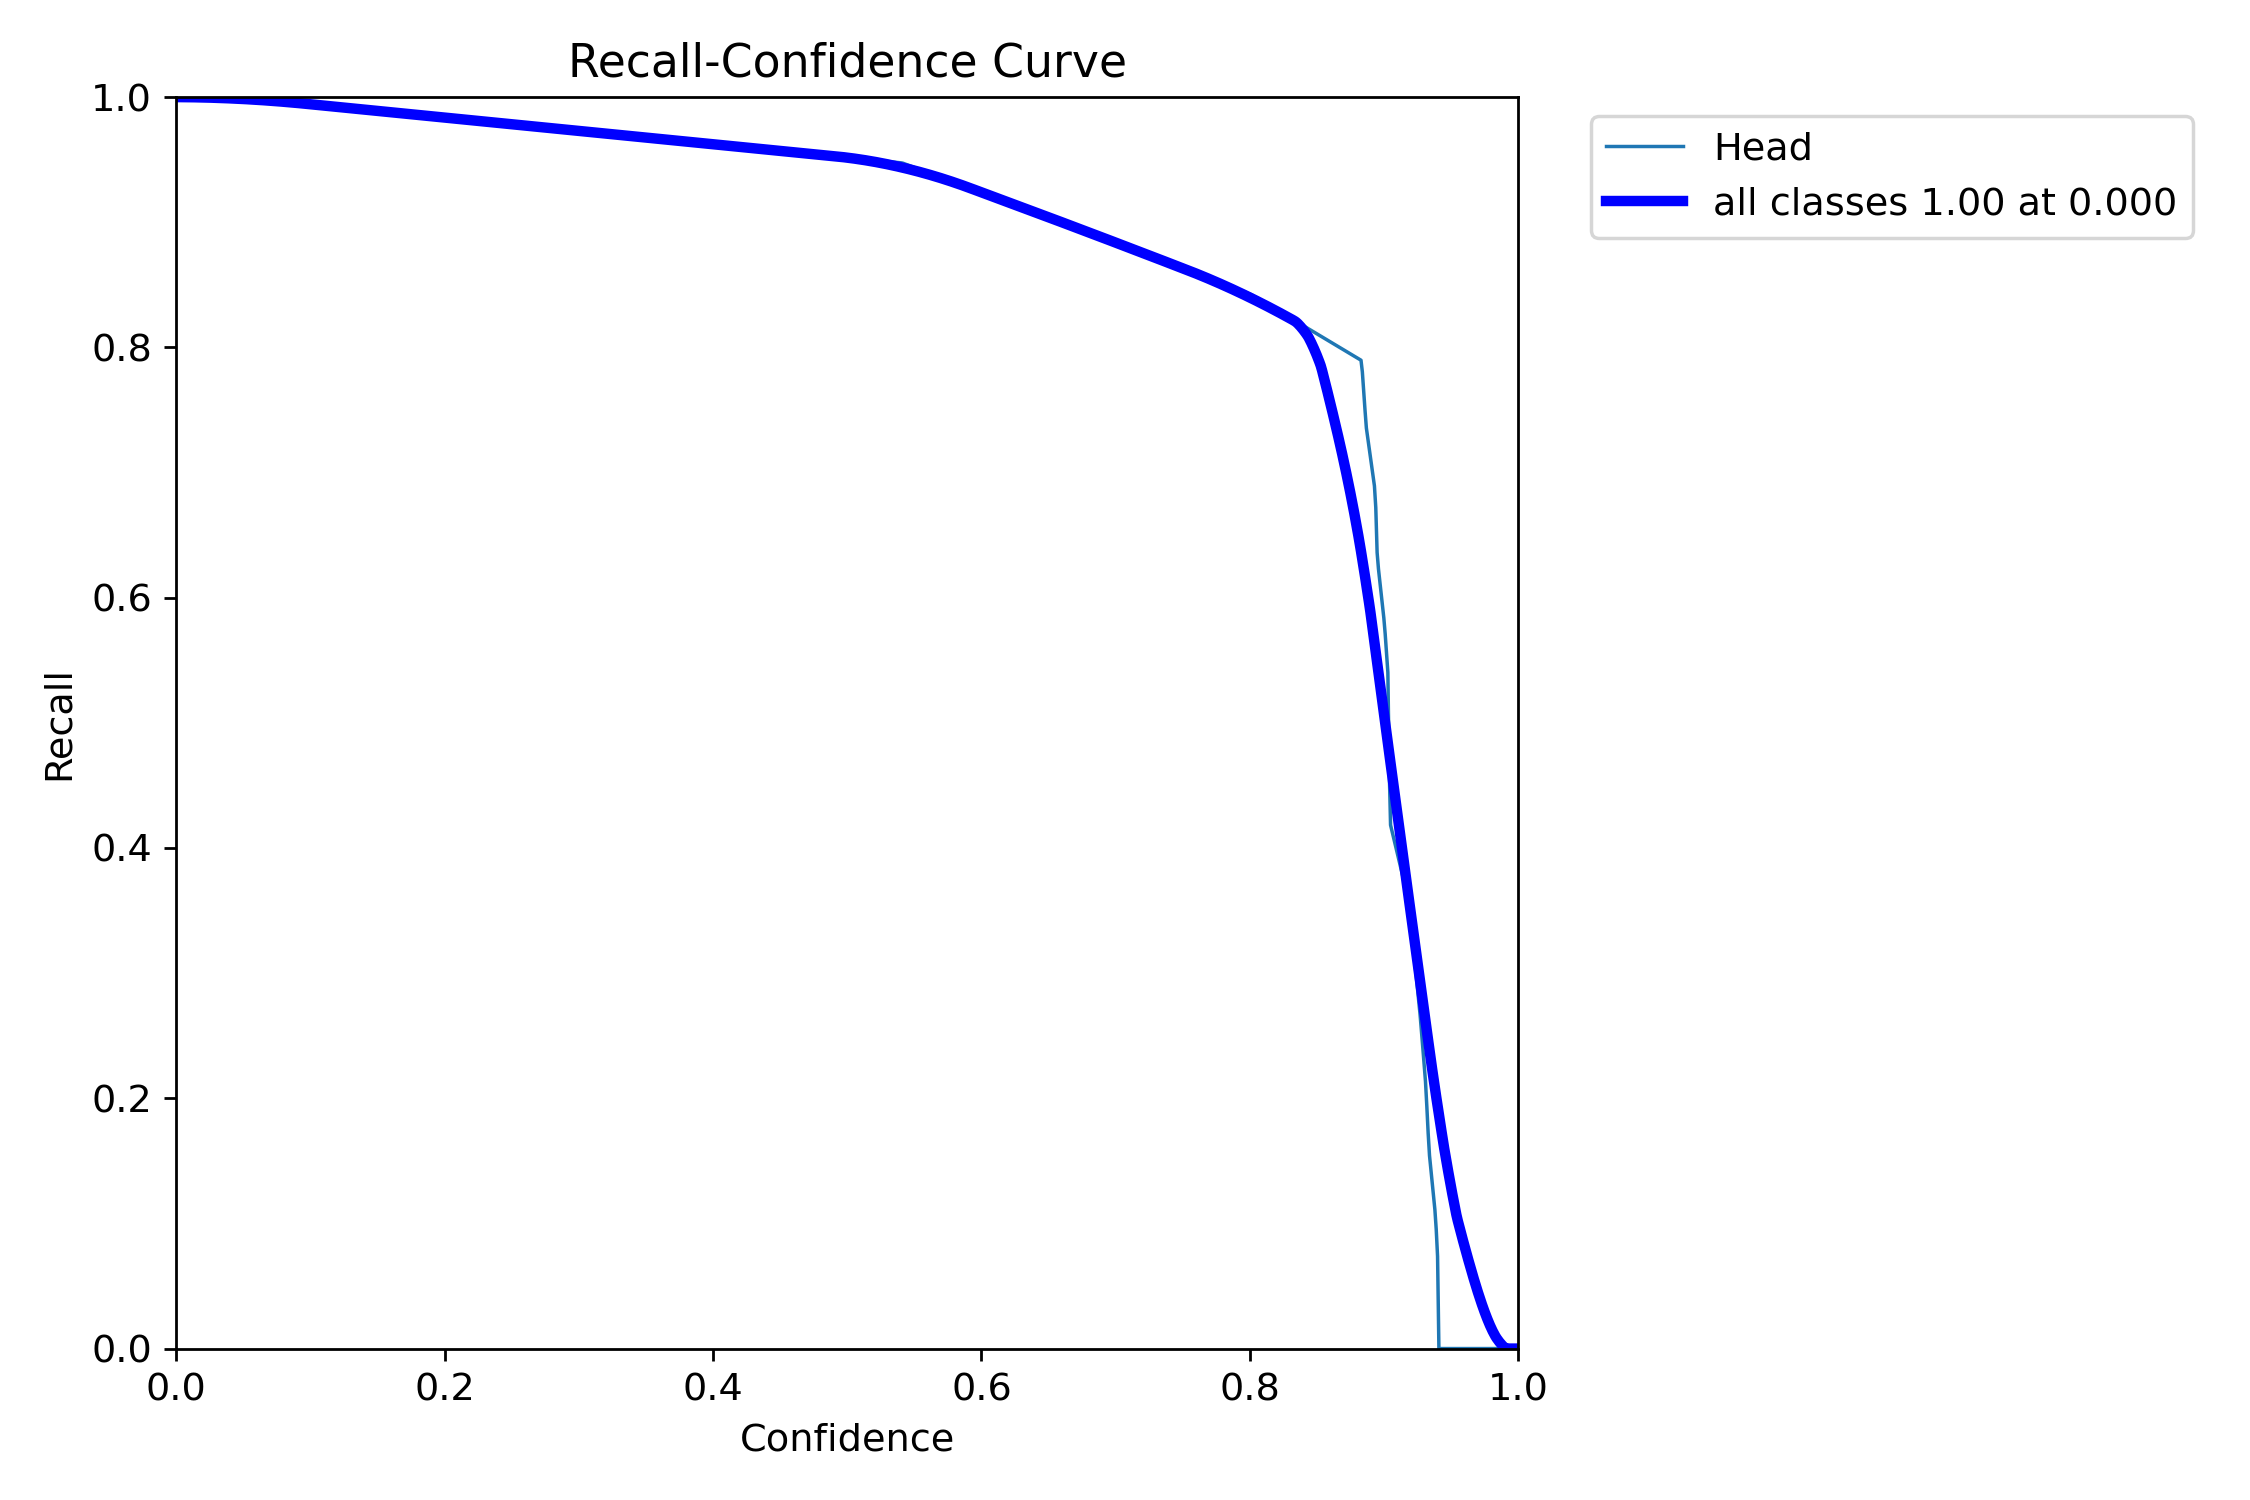

In [59]:
# Train segmentation model
model = YOLO("yolov8n-seg.pt")
model.train(data="data.yaml", epochs=50, imgsz=640)

# Load trained model
model = YOLO("runs/segment/train2/weights/best.pt")

# Display training metrics
train_path = "runs/segment/train2/"
for file in [
    "results.png",
    "confusion_matrix.png",
    "MaskF1_curve.png",
    "MaskPR_curve.png",
    "MaskR_curve.png",
]:
    display(Image(filename=train_path + file))

### HOG Feature Extraction 

In [60]:
def extract_hog_features(image_path):
    """Reads image, converts to gray, and extracts HOG features + visualization."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"⚠️ Failed to read image: {image_path}")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (128, 128))

    # HOG feature extraction
    features, hog_image = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True,
        transform_sqrt=True
    )

    return features, hog_image, gray

### Compare Two Images

In [61]:
def compare_images_hog(img1_path, img2_path):
    feat1, hog1, gray1 = extract_hog_features(img1_path)
    feat2, hog2, gray2 = extract_hog_features(img2_path)

    similarity = cosine_similarity([feat1], [feat2])[0][0]

    # --- Visualization ---
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f"HOG Feature Comparison | Cosine Similarity: {similarity:.3f}", fontsize=14, fontweight="bold")

    axes[0, 0].imshow(cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title("Image 1")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title("Image 2")
    axes[0, 1].axis("off")

    axes[1, 0].imshow(hog1, cmap="gray")
    axes[1, 0].set_title("HOG Visualization 1")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(hog2, cmap="gray")
    axes[1, 1].set_title("HOG Visualization 2")
    axes[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

    return similarity, fig

#### Feature Extraction and Comparision

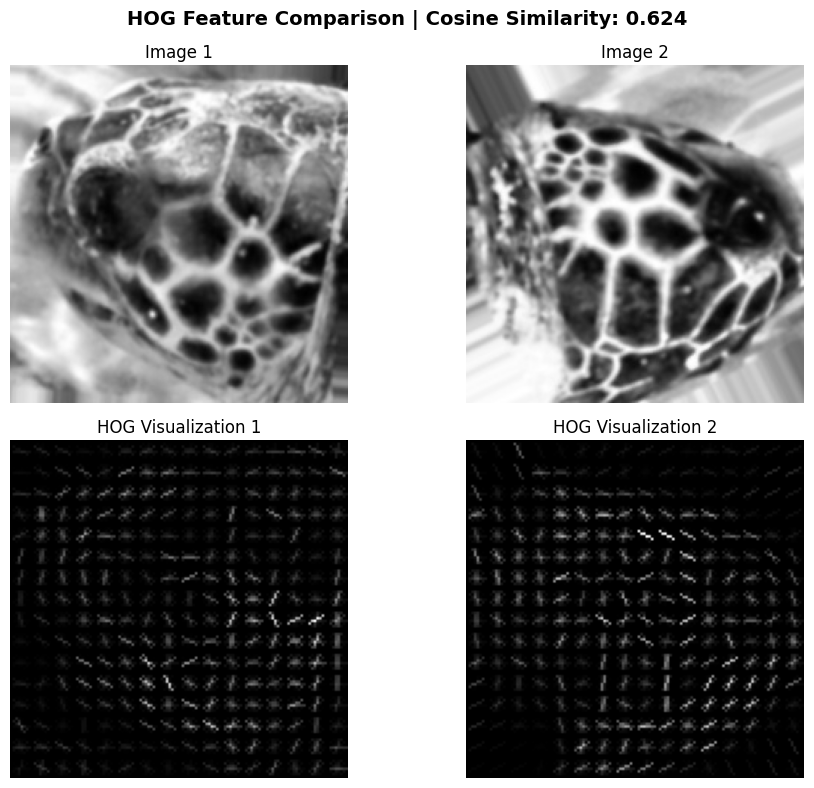

🔹 Cosine Similarity: 0.6237


In [62]:
img1 = "dataset_turtle_registered/CZS20-09/leftIMG_3995.JPG"
img2 = "dataset_turtle_registered/CZS20-09/leftIMG_9475.jpeg"

score, fig = compare_images_hog(img1, img2)
print(f"🔹 Cosine Similarity: {score:.4f}")

### Evaluation

In [63]:
dataset_dir = "dataset_turtle_registered"

num_positive = 30   # number of same-turtle pairs
num_negative = 30   # number of different-turtle pairs

def get_hog_similarity(img1, img2):
    f1, _, _ = extract_hog_features(img1)
    f2, _, _ = extract_hog_features(img2)
    return cosine_similarity([f1], [f2])[0][0]

turtle_images = {}
for identity in os.listdir(dataset_dir):
    path = os.path.join(dataset_dir, identity)
    if os.path.isdir(path):
        imgs = [os.path.join(path, f) for f in os.listdir(path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(imgs) > 1:
            turtle_images[identity] = imgs

#### Genarate Positive Pairs (Same Turtle)

In [66]:
positive_pairs = []
for turtle, imgs in turtle_images.items():
    pairs = list(combinations(imgs, 2))
    random.shuffle(pairs)
    positive_pairs.extend(pairs[:min(num_positive, len(pairs))])

#### Generate negative pairs (different turtles)

In [67]:
all_ids = list(turtle_images.keys())
negative_pairs = []
for _ in range(num_negative):
    id1, id2 = random.sample(all_ids, 2)
    img1 = random.choice(turtle_images[id1])
    img2 = random.choice(turtle_images[id2])
    negative_pairs.append((img1, img2))

#### Compute similarities

In [68]:
pos_scores, neg_scores = [], []

print("🔍 Evaluating positive pairs...")
for img1, img2 in tqdm(positive_pairs):
    try:
        pos_scores.append(get_hog_similarity(img1, img2))
    except:
        continue

print("🔍 Evaluating negative pairs...")
for img1, img2 in tqdm(negative_pairs):
    try:
        neg_scores.append(get_hog_similarity(img1, img2))
    except:
        continue

🔍 Evaluating positive pairs...


100%|██████████| 1200/1200 [01:25<00:00, 14.06it/s]


🔍 Evaluating negative pairs...


100%|██████████| 30/30 [00:02<00:00, 12.62it/s]


In [69]:
print(f"Done. {len(pos_scores)} positive and {len(neg_scores)} negative pairs evaluated.")

Done. 1200 positive and 30 negative pairs evaluated.


##### Visualize & Compute Evaluation Metrics

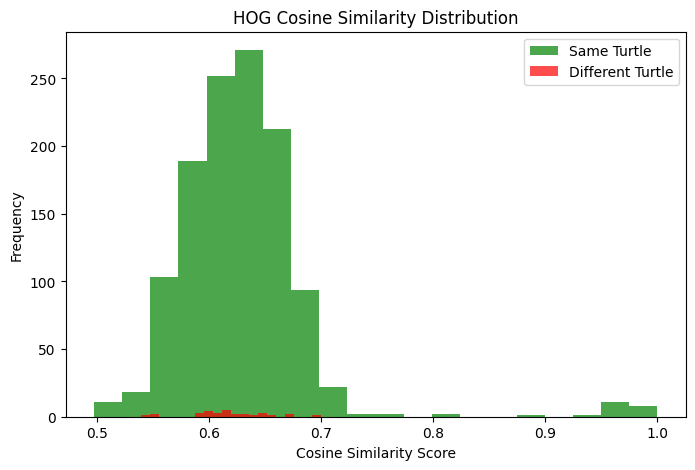

In [70]:
# --- Histogram of scores ---
plt.figure(figsize=(8,5))
plt.hist(pos_scores, bins=20, alpha=0.7, label="Same Turtle", color="green")
plt.hist(neg_scores, bins=20, alpha=0.7, label="Different Turtle", color="red")
plt.title("HOG Cosine Similarity Distribution")
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


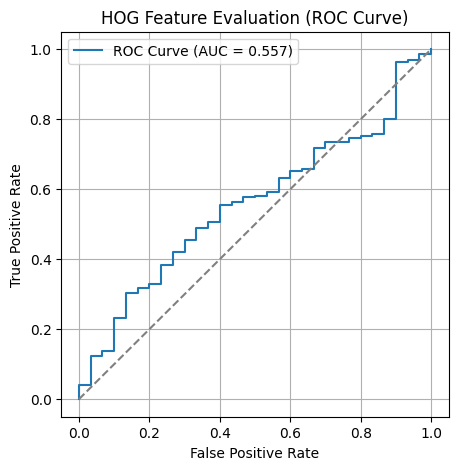

In [71]:
y_true = [1]*len(pos_scores) + [0]*len(neg_scores)
y_scores = pos_scores + neg_scores
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('HOG Feature Evaluation (ROC Curve)')
plt.legend()
plt.grid(True)
plt.show()


In [72]:
print(f"📈 AUC Score: {roc_auc:.3f}")
print(f"Mean Positive Similarity: {np.mean(pos_scores):.3f}")
print(f"Mean Negative Similarity: {np.mean(neg_scores):.3f}")

📈 AUC Score: 0.557
Mean Positive Similarity: 0.629
Mean Negative Similarity: 0.617
